# Workflow to study cell-type dependent structures

by Pu Zheng

2022.10.19

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

18856


In [2]:
# Required plotting setting
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _single_col_width, _double_col_width, _font_size, _ticklabel_size,_ticklabel_width

from matplotlib import cm
#from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   


## 0.1 Folders

In [112]:
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920'
# specifically for the first jupyter:
if not os.path.exists(postanalysis_folder):
    print(f"create postanalysis_folder: {postanalysis_folder}")
    os.makedirs(postanalysis_folder)
else:
    print(f"use postanalysis_folder: {postanalysis_folder}")

# figure folder    
dark_mode = True
if dark_mode:
    figure_folder = os.path.join(postanalysis_folder, 'Figures_0920_dark')
    plt.style.use('dark_background')
else:
    figure_folder = os.path.join(postanalysis_folder, 'Figures_0920')
    plt.style.use('default')

if not os.path.exists(figure_folder):
    print(f"create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"use figure_folder: {figure_folder}")

use postanalysis_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920
use figure_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920\Figures_0920_dark


In [113]:
subclass_variation_figure_folder = os.path.join(figure_folder, 'variation_subclass')

if not os.path.exists(subclass_variation_figure_folder):
    print(f"Create: {subclass_variation_figure_folder}")
    os.makedirs(subclass_variation_figure_folder)
else:
    print(f"Use: {subclass_variation_figure_folder}")

Use: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920\Figures_0920_dark\variation_subclass


## 0.2 Load subclass cell type dict

In [11]:
%%time
subclass_2_chr2ZxysList_filename = os.path.join(postanalysis_folder, 'subclass_2_chr2Zxys.pkl')
subclass_2_cellInfoList_filename = os.path.join(postanalysis_folder, 'subclass_2_cellInfo.pkl')

print("Loading single-cells")
subclass_2_chr2ZxysList = pickle.load(open(subclass_2_chr2ZxysList_filename, 'rb'))
subclass_2_cellInfoList = pickle.load(open(subclass_2_cellInfoList_filename, 'rb'))

Loading single-cells
Wall time: 8.52 s


In [10]:
%%time
# subclass to median distance dict
subclass_2_median_filename = os.path.join(postanalysis_folder, 'subclass_2_medianDict.pkl')
print("Loading median")
subclass_2_medianDict = pickle.load(open(subclass_2_median_filename, 'rb'))

Loading median
Wall time: 299 ms


## 0.3 load codebook

In [12]:
import pandas as pd
from ImageAnalysis3.structure_tools import distance
# load codebook
codebook = pd.read_csv(r'\\10.245.74.158\Chromatin_NAS_8\Exported_data\20220713-Export\merged_codebook.csv')
# partition by chr
chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook, codebook, sort_by_region=False)## load codebook

## 0.4 load compartments

In [49]:
ensemble_normedPC1_filename = os.path.join(postanalysis_folder, 'ensemble_pc1.npy')
ensemble_normedPC1 = np.load(ensemble_normedPC1_filename)

# define AB
ensemble_AB_dict = {}
AB_th = -0.5
ensemble_AB_dict['A'] = np.where(ensemble_normedPC1 > AB_th)[0]
ensemble_AB_dict['B'] = np.where(ensemble_normedPC1 <= AB_th)[0]

# each chr
chr_2_AB_dict = {}

for _chr in np.unique(codebook['chr']):
    if _chr == 'Y':
        continue
    _chr_AB_dict = {'A':[],'B':[]}
    for _i, _ind in enumerate(chr_2_indices[_chr]):
        if _ind in ensemble_AB_dict['A']:
            _chr_AB_dict['A'].append(_i)
        if _ind in ensemble_AB_dict['B']:
            _chr_AB_dict['B'].append(_i)
    _chr_AB_dict = {_k:np.array(_v, dtype=np.int32) for _k,_v in _chr_AB_dict.items()}
    chr_2_AB_dict[_chr] = _chr_AB_dict

# 1. ScatterPlot

In [14]:
sel_chr = '7'
sel_cls_1 = 'L2/3 IT'
sel_cls_2 = 'Oligo'

mat_1 = subclass_2_medianDict[sel_cls_1][f"cis_{sel_chr}"]
mat_2 = subclass_2_medianDict[sel_cls_2][f"cis_{sel_chr}"]

In [15]:
from sklearn.linear_model import LinearRegression
#run regression
X = mat_1[np.triu_indices_from(mat_1,1)][:,np.newaxis]
y = mat_2[np.triu_indices_from(mat_2,1)]
#sel_inds = np.where()
reg = LinearRegression(fit_intercept=False).fit(X, y)
#Returns the coefficient of determination R^2 of the prediction.
reg.score(X, y)
#0.9725287282456724

0.8635737217628975

save figure: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920\Figures_0920_dark\variation_subclass\scatter_chr7_L2-3_IT-Oligo.pdf


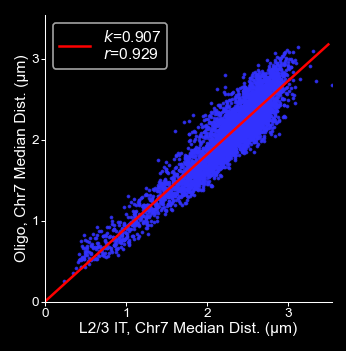

In [17]:
fig, ax = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=150)
ax.scatter(X[:,0], y, s=1, color=[0.2,0.2,1],#color=[0,0,0.5], 
           alpha=0.8)
line_x = np.arange(0, np.max(X), 0.1)
ax.plot(line_x[:,np.newaxis], reg.predict(line_x[:,np.newaxis]), 
        color='r', label=f'$k$={reg.coef_[0]:.3f}\n$r$={np.sqrt(reg.score(X, y)):.3f}')
ax.legend(fontsize=_font_size)

vmax = max(np.max(X), np.max(y))
ax.set_xlim([0, vmax])
ax.set_ylim([0, vmax])
ax.set_xticks(np.arange(0, vmax, 1))
ax.set_yticks(np.arange(0, vmax, 1))

ax.set_xlabel(f"{sel_cls_1}, Chr{sel_chr} Median Dist."+' (\u03BCm)', fontsize=_font_size, labelpad=1)
ax.set_ylabel(f"{sel_cls_2}, Chr{sel_chr} Median Dist."+' (\u03BCm)', fontsize=_font_size, labelpad=1)

ax.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]
ax.spines["top"].set_visible(False) # remove top frame
ax.spines["right"].set_visible(False) #remove right frame

fig.subplots_adjust(wspace=0.0, hspace=0.0, left=0.12, right=0.97, top=0.97, bottom=0.12)

fig_filename = os.path.join(
    subclass_variation_figure_folder, 
    f"scatter_chr{sel_chr}_{sel_cls_1.replace('/','-').replace(' ','_')}-{sel_cls_2.replace('/','-').replace(' ','_')}.pdf")
print(f"save figure: {fig_filename}")
plt.savefig(fig_filename, transparent=True, bbox_inches='tight', dpi=300)
plt.savefig(fig_filename.replace('.pdf', '.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

## 1.2 residual

In [18]:
y_pred = reg.predict(X)
residual_mat = reg.predict(np.reshape(mat_1, -1)[:,np.newaxis]).reshape(mat_1.shape) - mat_2

save figure: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920\Figures_0920_dark\variation_subclass\residual_heatmap_chr7_L2-3_IT-Oligo.pdf


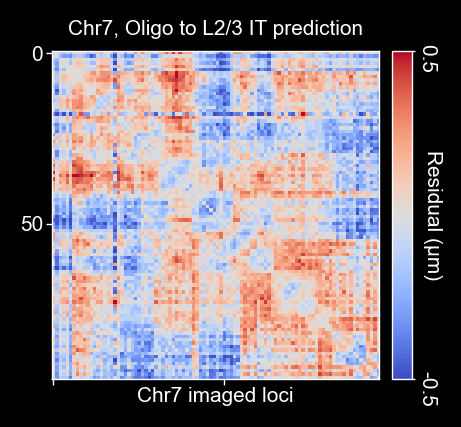

In [19]:
fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=200)

# create a color map
#residual_cmap = cm.get_cmap('RdYlBu').copy()
residual_cmap = cm.get_cmap('coolwarm').copy()
residual_cmap.set_bad(color=[0.5,0.5,0.5,1])

vmin,vmax = -0.5, 0.5

_pf = ax1.imshow(residual_mat, 
                 cmap=residual_cmap, vmin=vmin, vmax=vmax, interpolation='nearest')

ax1.set_title(f"Chr{sel_chr}, {sel_cls_2} to {sel_cls_1} prediction", fontsize=_font_size)
ax1.set_xlabel(f"Chr{sel_chr} imaged loci", fontsize=_font_size, labelpad=3)
ax1.set_yticks(np.arange(0, len(chr_2_orders[sel_chr]), 50))
#ax1.set_yticklabels(_chr_names[:-1],)
ax1.set_xticks( np.arange(0, len(chr_2_orders[sel_chr]), 50))
#ax1.set_xticklabels(_chr_names[:-1], rotation=45)

ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.yaxis.set_tick_params(which='both', labelleft=True)
ax1.set_xlim([-0.5, len(chr_2_orders[sel_chr])-0.5])
ax1.set_ylim([len(chr_2_orders[sel_chr])-0.5, -0.5])

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]

# locate ax1
divider = make_axes_locatable(ax1)
# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1)
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in cbar.ax.spines.items()]

cbar.set_ticks([vmin,vmax])
cbar.ax.set_yticklabels([vmin,vmax], rotation=270)
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Residual (\u03BCm)', 
               fontsize=_font_size, labelpad=2, rotation=270)
cbar.ax.minorticks_off()
fig.subplots_adjust(wspace=0.05, hspace=0.2, left=0.1, right=0.9, top=0.9, bottom=0.1)


fig_filename = os.path.join(
    subclass_variation_figure_folder, 
    f"residual_heatmap_chr{sel_chr}_{sel_cls_1.replace('/','-').replace(' ','_')}-{sel_cls_2.replace('/','-').replace(' ','_')}.pdf")
print(f"save figure: {fig_filename}")
plt.savefig(fig_filename, transparent=True, bbox_inches='tight', dpi=300)
plt.savefig(fig_filename.replace('.pdf', '.png'), transparent=True, bbox_inches='tight', dpi=300)
plt.show()

# 2. Variational Analysis

for each chromosome, calculate pairwise correlation between subclasses

In [22]:
from sklearn.linear_model import LinearRegression


import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

# mininum number of cells 
num_th = 500

_celltype_order = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L6 CT','L6b','L5 ET','L5/6 NP',
     'Sst','Pvalb','Vip','Lamp5','Sncg',
     'Astro','Oligo','OPC','Endo','Micro','Peri','SMC','VLMC',
    ]
sel_celltypes = [_c for _c in _celltype_order if len(subclass_2_chr2ZxysList[_c]) > num_th]

In [26]:

chr_2_correlationDf = {}
chr_2_slopeDf = {}
chr_2_residual_mats = {}

for sel_chr in chr_2_indices:
    if sel_chr in ['Y']:
        continue
    # init for this chr
    _residual_mats = []
    correlation_dicts = {'cell type':[_subcls for _subcls in _celltype_order if len(subclass_2_chr2ZxysList[_subcls]) >= num_th]}
    slope_dicts = {'cell type':[_subcls for _subcls in _celltype_order if len(subclass_2_chr2ZxysList[_subcls]) >= num_th]}
    # loop through pair of cell types
    for _subcls_1 in _celltype_order:
        if len(subclass_2_chr2ZxysList[_subcls_1]) < num_th:
            continue
        _mat_1 = subclass_2_medianDict[_subcls_1][f'cis_{sel_chr}']
        _reg_rs = []
        _reg_ks = []
        for _subcls_2 in _celltype_order:
            _mat_2 = subclass_2_medianDict[_subcls_2][f'cis_{sel_chr}']
            if len(subclass_2_chr2ZxysList[_subcls_2]) < num_th:
                continue
            #run regression
            X = _mat_1[np.triu_indices_from(_mat_1,1)]
            y = _mat_2[np.triu_indices_from(_mat_2,1)]
            valid_inds = (np.isfinite(X) & np.isfinite(y))
            #print(np.sum(valid_inds), _subcls_1)
            X = X[valid_inds,np.newaxis]
            y = y[valid_inds]
            #sel_inds = np.where()
            reg = LinearRegression(fit_intercept=False).fit(X, y)
            #Returns the coefficient of determination R^2 of the prediction.
            _r = np.sqrt(reg.score(X, y))
            _reg_rs.append(_r)
            _reg_ks.append(reg.coef_[0])
            # residual
            _valid_mat1 = _mat_1[np.isfinite(_mat_1)]
            _pred_valid_mat1 = reg.predict(_valid_mat1[:,np.newaxis])
            _pred_mat1 = np.ones_like(_mat_1) * np.nan
            _pred_mat1[np.isfinite(_mat_1)] = _pred_valid_mat1
            # residual
            _rmat = _pred_mat1 - _mat_2
            # append
            _residual_mats.append(_rmat)
            
        correlation_dicts[_subcls_1] = _reg_rs
        slope_dicts[_subcls_1] = _reg_ks
    # append as DF
    correlation_df = pd.DataFrame(correlation_dicts).set_index('cell type')  
    chr_2_correlationDf[sel_chr] = correlation_df
    slope_df = pd.DataFrame(slope_dicts).set_index('cell type')  
    chr_2_slopeDf[sel_chr] = slope_df
    _residual_mats = np.array(_residual_mats)
    _residual_mats = _residual_mats.reshape(len(sel_celltypes),len(sel_celltypes), 
                                          _residual_mats.shape[-2],_residual_mats.shape[-1],  )
    chr_2_residual_mats[sel_chr] = _residual_mats

In [25]:
chr_2_correlationDf['7']

,L2/3 IT,L4/5 IT,L5 IT,L6 IT,L6 CT,L6b,L5 ET,L5/6 NP,Sst,Pvalb,Astro,Oligo,OPC,Endo,Micro,Peri
cell type,,,,,,,,,,,,,,,,
L2/3 IT,1.000000,0.964664,0.965478,0.968013,0.969505,0.940577,0.929883,0.927583,0.933341,0.947059,0.929383,0.917069,0.923121,0.886756,0.870445,0.813619
L4/5 IT,0.966344,1.000000,0.966452,0.966659,0.971351,0.948492,0.938129,0.928473,0.935338,0.942438,0.945433,0.940200,0.940937,0.893426,0.878518,0.833215
L5 IT,0.968142,0.967497,1.000000,0.961524,0.964042,0.944546,0.942310,0.924492,0.935317,0.951091,0.936928,0.927989,0.925765,0.897345,0.878865,0.843202
L6 IT,0.968900,0.965968,0.959457,1.000000,0.969962,0.937299,0.930591,0.925610,0.929683,0.939716,0.931284,0.921847,0.923256,0.878715,0.866601,0.813811
L6 CT,0.970486,0.970891,0.962286,0.970098,1.000000,0.944633,0.931129,0.943196,0.934850,0.937387,0.936367,0.926556,0.946935,0.873472,0.862019,0.803564
L6b,0.946066,0.950880,0.945403,0.941452,0.948048,1.000000,0.921815,0.910726,0.914209,0.923959,0.930854,0.929227,0.920148,0.893415,0.875310,0.833108
L5 ET,0.939233,0.943639,0.945729,0.938099,0.938291,0.925332,1.000000,0.905043,0.920676,0.931571,0.923254,0.918444,0.908585,0.887947,0.862621,0.834403
L5/6 NP,0.934645,0.932166,0.926045,0.930916,0.946968,0.911180,0.901023,1.000000,0.902456,0.907866,0.899757,0.889205,0.903754,0.837781,0.825281,0.769403
Sst,0.941217,0.940086,0.938110,0.936205,0.940603,0.916648,0.919288,0.904763,1.000000,0.927921,0.914841,0.904633,0.910372,0.878809,0.857740,0.817874


In [37]:


# calculate variational mat
chr_2_subclass_variation_mat = {}
for _sel_chr in chr_2_residual_mats:
    if _sel_chr != 'Y':
        chr_2_subclass_variation_mat[_sel_chr] = \
        np.nanstd(chr_2_residual_mats[_sel_chr][np.triu_indices(len(sel_celltypes),1)], axis=0)


save figure: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920\Figures_0920_dark\variation_subclass\variation_all_heatmap_chr7.pdf


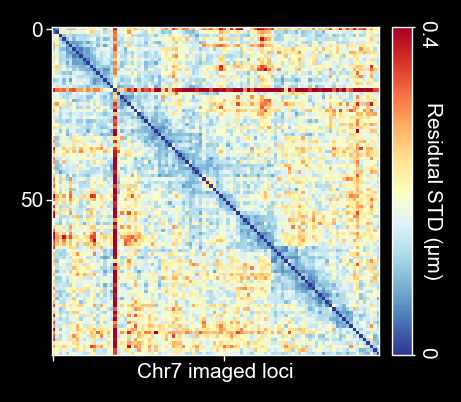

In [33]:
plot_chr = '7'

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=200)
# create a color map
residual_cmap = cm.get_cmap('RdYlBu_r').copy()
residual_cmap.set_bad(color=[0.5,0.5,0.5,1])

vmin,vmax = 0, 0.4

_pf = ax1.imshow(chr_2_subclass_variation_mat[plot_chr], 
                 cmap=residual_cmap, vmin=vmin, vmax=vmax, interpolation='nearest')

#ax1.set_title(f"Chr{plot_chr}, standard deviation of residuals", fontsize=_font_size)
ax1.set_xlabel(f"Chr{plot_chr} imaged loci", fontsize=_font_size, labelpad=3)
ax1.set_yticks(np.arange(0, len(chr_2_orders[plot_chr]), 50))
#ax1.set_yticklabels(_chr_names[:-1],)
ax1.set_xticks( np.arange(0, len(chr_2_orders[plot_chr]), 50))
#ax1.set_xticklabels(_chr_names[:-1], rotation=45)

ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.yaxis.set_tick_params(which='both', labelleft=True)
ax1.set_xlim([-0.5, len(chr_2_orders[plot_chr])-0.5])
ax1.set_ylim([len(chr_2_orders[plot_chr])-0.5, -0.5])

ax1.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]

# locate ax1
divider = make_axes_locatable(ax1)
# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1)
cbar.ax.tick_params('both', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in cbar.ax.spines.items()]

cbar.set_ticks([vmin,vmax])
cbar.ax.set_yticklabels([vmin,vmax], rotation=270)
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Residual STD (\u03BCm)', 
               fontsize=_font_size, labelpad=2, rotation=270)
cbar.ax.minorticks_off()
fig.subplots_adjust(wspace=0.05, hspace=0.2, left=0.1, right=0.9, top=0.9, bottom=0.1)


fig_filename = os.path.join(
    subclass_variation_figure_folder, 
    f"variation_all_heatmap_chr{plot_chr}.pdf")

print(f"save figure: {fig_filename}")
plt.savefig(fig_filename, transparent=True, bbox_inches='tight', dpi=300)
plt.savefig(fig_filename.replace('.pdf', '.png'), transparent=True, bbox_inches='tight', dpi=300)

plt.show()

## Plot together with compartment

save figure: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920\Figures_0920\variation_subclass\variation_all_heatmap_with_AB_chr7.pdf


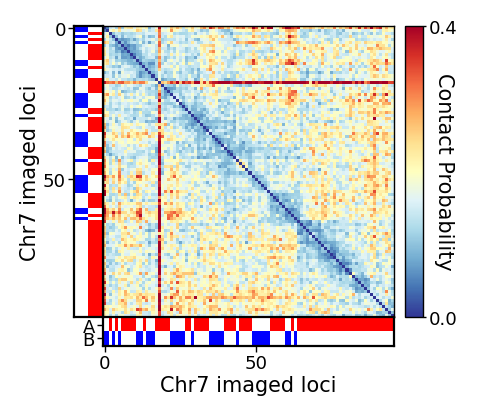

In [78]:
plot_chr = '7'

fig, ax1 = plt.subplots(figsize=(_single_col_width, _single_col_width), dpi=200)
# create a color map
residual_cmap = cm.get_cmap('RdYlBu_r').copy()
residual_cmap.set_bad(color=[0.5,0.5,0.5,1])

vmin,vmax = 0, 0.4

_pf = ax1.imshow(chr_2_subclass_variation_mat[plot_chr], 
                 cmap=residual_cmap, vmin=vmin, vmax=vmax, interpolation='nearest')

#ax1.set_title(f"Chr{plot_chr}, standard deviation of residuals", fontsize=_font_size)
ax1.set_yticks(np.arange(0, len(chr_2_orders[plot_chr]), 50))
#ax1.set_yticklabels(_chr_names[:-1],)

#ax1.set_xticklabels(_chr_names[:-1], rotation=45)

ax1.xaxis.set_tick_params(which='both', labelbottom=True)
ax1.yaxis.set_tick_params(which='both', labelleft=True)
ax1.set_xlim([-0.5, len(chr_2_orders[plot_chr])-0.5])
ax1.set_ylim([len(chr_2_orders[plot_chr])-0.5, -0.5])

ax1.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax1.spines.items()]

# locate ax1
divider = make_axes_locatable(ax1)
# colorbar ax
cax = divider.append_axes('right', size='6%', pad="4%")
cbar = plt.colorbar(_pf,cax=cax, ax=ax1)
cbar.ax.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size-1,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in cbar.ax.spines.items()]

cbar.set_ticks([vmin,vmax])
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Contact Probability', 
               fontsize=_font_size, labelpad=-1, rotation=270)
cbar.ax.minorticks_off()

# create bottom ax
bot_ax = divider.append_axes('bottom', size='10%', pad="0%", 
                             sharex=ax1, xticks=[])
bot_ax.bar(chr_2_AB_dict[plot_chr]['A'], 1, 
           color='r',width=1, bottom=0)
bot_ax.bar(chr_2_AB_dict[plot_chr]['B'], -1, 
           color='b',width=1, bottom=0)

bot_ax.tick_params('both', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True, labelbottom=True)

bot_ax.set_xlabel(f"Chr{plot_chr} imaged loci", fontsize=_font_size, labelpad=1)
bot_ax.set_xticks( np.arange(0, len(chr_2_orders[plot_chr]), 50))
bot_ax.set_yticks([0.5,-0.5])
bot_ax.set_yticklabels(["A","B"])

# create left ax
left_ax = divider.append_axes('left', size='10%', pad="0%", 
                             sharey=ax1, xticks=[])
left_ax.barh(chr_2_AB_dict[plot_chr]['A'], height=1, 
           color='r',width=1, left=0)
left_ax.barh(chr_2_AB_dict[plot_chr]['B'], height=-1,
           color='b',width=1, left=-1)

left_ax.tick_params('y', labelsize=_font_size-1, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True, labelbottom=False)
left_ax.tick_params('x', labelsize=_font_size-1, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=True, labelbottom=False)

left_ax.set_ylabel(f"Chr{plot_chr} imaged loci", fontsize=_font_size, labelpad=1)
left_ax.set_yticks( np.arange(0, len(chr_2_orders[plot_chr]), 50))
#left_ax.set_xticks([0.5,-0.5])
#left_ax.set_xticklabels(["A","B"])


# sort ax1 direction
#ax1.set_xlim([chr_2_indices[left_chr].min(), chr_2_indices[right_chr].max()])
#ax1.set_ylim([chr_2_indices[right_chr].max(), chr_2_indices[left_chr].min()])

fig_filename = os.path.join(
    subclass_variation_figure_folder, 
    f"variation_all_heatmap_with_AB_chr{plot_chr}.pdf")

print(f"save figure: {fig_filename}")
plt.savefig(fig_filename, transparent=True, bbox_inches='tight', dpi=300)
plt.savefig(fig_filename.replace('.pdf', '.png'), transparent=True, bbox_inches='tight', dpi=300)

plt.show()

In [41]:
chr_AB_dict

{'A': array([], dtype=int32), 'B': array([], dtype=int32)}

['L2/3 IT',
 'L4/5 IT',
 'L5 IT',
 'L6 IT',
 'L6 CT',
 'L6b',
 'L5 ET',
 'L5/6 NP',
 'Sst',
 'Pvalb',
 'Astro',
 'Oligo',
 'OPC',
 'Endo',
 'Micro',
 'Peri']

save figure: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_0920\Figures_0920_dark\variation_subclass\slope_subclass_summary_chr7.pdf


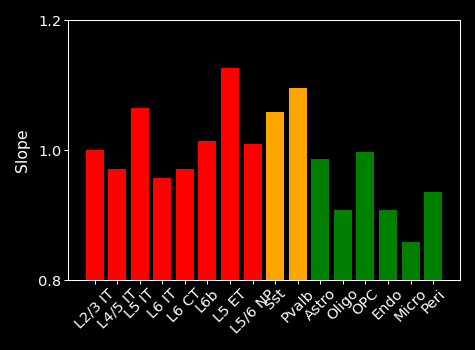

In [119]:
fig, ax = plt.subplots(figsize=(_single_col_width*1.5, _single_col_width), dpi=150)
color = ['red']*8 + ['orange']*2 + ['green']*6
ax.bar(x=np.arange(len(sel_celltypes)), height=chr_2_slopeDf['7']['L2/3 IT'].values, 
      color=color)
ax.set_ylim([0.8,1.2])
ax.set_yticks([0.8,1,1.2])
ax.set_ylabel('Slope', fontsize=_font_size)
ax.set_xticks(np.arange(len(sel_celltypes)))
ax.set_xticklabels(list(chr_2_slopeDf['7'].columns), fontsize=_font_size,rotation=45)
ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in ax.spines.items()]

fig_filename = os.path.join(
    subclass_variation_figure_folder, 
    f"slope_subclass_summary_chr{plot_chr}.pdf")

print(f"save figure: {fig_filename}")
plt.savefig(fig_filename, transparent=True, bbox_inches='tight', dpi=300)
plt.savefig(fig_filename.replace('.pdf', '.png'), transparent=True, bbox_inches='tight', dpi=300)

plt.show()

In [102]:
color

['red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'red',
 'orange',
 'orange',
 'green',
 'green',
 'green',
 'green',
 'green',
 'green']